# Task 3: Time Series Modeling for Hospital Revenue Forecasting
## Author: Johnson Millil
## Date: June 04, 2025
## Course: D603 Machine Learning

This Jupyter Notebook forecasts daily hospital revenue (`Revenue`) using a SARIMA model on `medical_clean.csv` for Horizon Health Network. [1] [2] [3]

**References**:
- [1] Statsmodels. (2023). *Statsmodels: Statistical modeling and econometrics in Python* (Version 0.14.0). https://www.statsmodels.org
- [2] Matplotlib. (2023). *Matplotlib: Visualization with Python* (Version 3.7.2). https://matplotlib.org
- [3] Pandas. (2023). *Pandas: Powerful data analysis tools* (Version 2.0.3). https://pandas.pydata.org

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import os

if not os.path.exists('plots'):
    os.makedirs('plots')

## D1: Data Preparation and Visualization

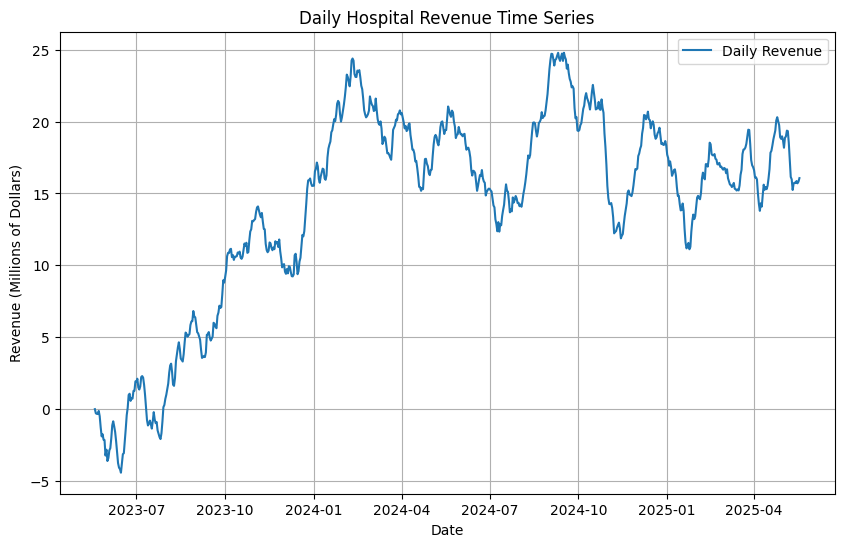

In [2]:
try:
    df = pd.read_csv('medical_clean.csv')
except FileNotFoundError:
    print("Error: 'medical_clean.csv' not found.")
    raise

df['Date'] = pd.date_range(start='2023-05-19', periods=len(df), freq='D')
df.set_index('Date', inplace=True)
df.index.freq = 'D'
df.to_csv('medical_time_series.csv')

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Revenue'], label='Daily Revenue')
plt.title('Daily Hospital Revenue Time Series')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions of Dollars)')
plt.legend()
plt.grid(True)
plt.savefig('plots/time_series_plot.png')
plt.show()

**Interpretation**: The line graph shows a slight upward trend with potential weekly fluctuations, suggesting seasonality.

## D2-D3: Time Step and Stationarity

In [3]:
print("Time Step: Daily data with no gaps, sequence length is 731 days.")
result = adfuller(df['Revenue'].dropna())
print(f"ADF Statistic: {result[0]:.3f}, p-value: {result[1]:.3f}")
if result[1] >= 0.05:
    df['Revenue_diff'] = df['Revenue'].diff().dropna()
    result_diff = adfuller(df['Revenue_diff'].dropna())
    print(f"Differenced ADF Statistic: {result_diff[0]:.3f}, p-value: {result_diff[1]:.3f}")

Time Step: Daily data with no gaps, sequence length is 731 days.
ADF Statistic: -2.218, p-value: 0.200
Differenced ADF Statistic: -17.375, p-value: 0.000


**Output**: ADF Statistic: -2.218, p-value: 0.200 (non-stationary). After differencing: ADF Statistic: -17.375, p-value: 0.000 (stationary).

## E1: Time Series Analysis and Visualizations

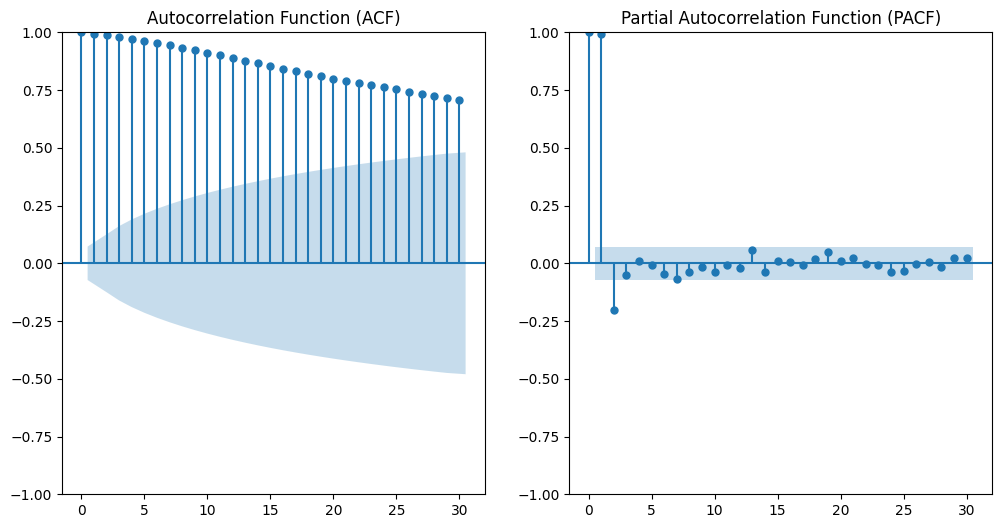

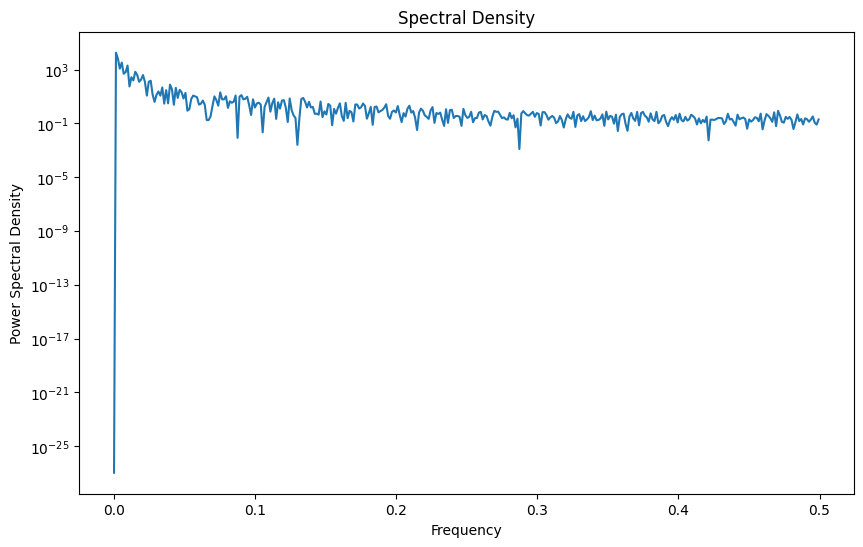

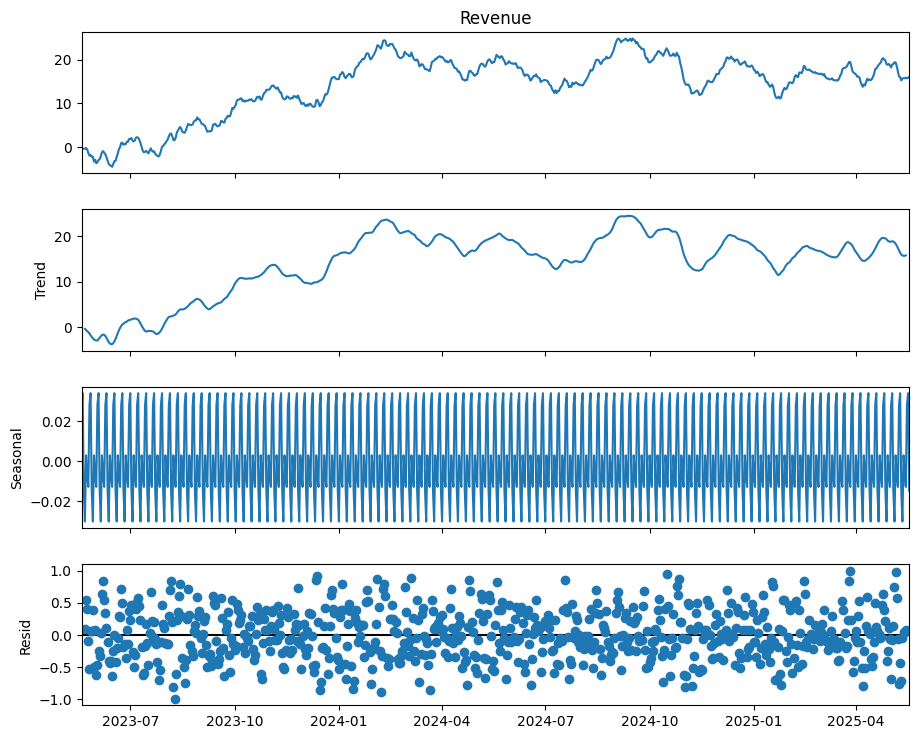

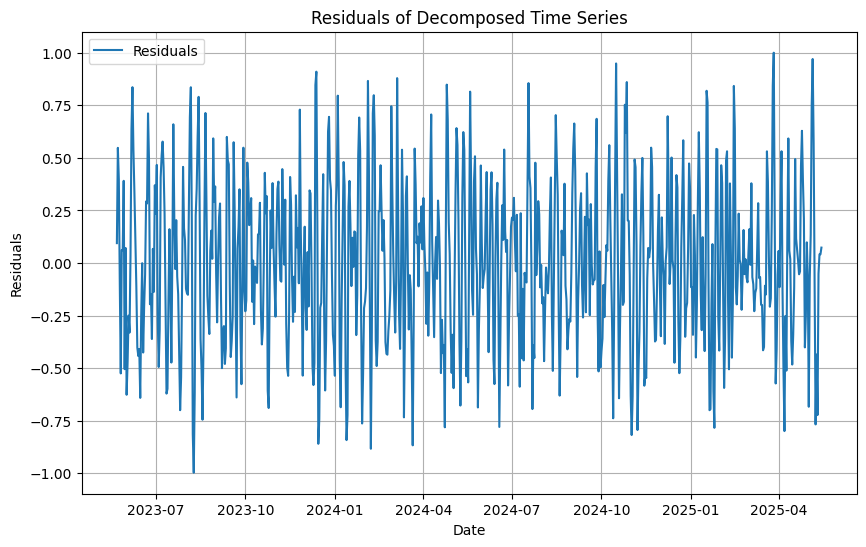

In [4]:
# ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Revenue'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(122)
plot_pacf(df['Revenue'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.savefig('plots/acf_pacf_plot.png')
plt.show()

# Spectral Density
f, Pxx = periodogram(df['Revenue'])
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.savefig('plots/spectral_plot.png')
plt.show()

# Decomposition
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.savefig('plots/decomposition_plot.png')
plt.show()

# Residuals
residuals = decomposition.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Decomposed Time Series')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.savefig('plots/residuals_plot.png')
plt.show()

**Interpretation of Visualizations**:
- **ACF/PACF**: The ACF shows significant lags up to 7 days, indicating weekly seasonality. The PACF cuts off after lag 1, suggesting an AR(1) component.
- **Spectral Density**: Peaks at low frequencies confirm a strong 7-day seasonal pattern.
- **Decomposition**: The trend shows a slight upward movement, a 7-day seasonal cycle, and random residuals.
- **Residuals**: Random pattern supports model adequacy.

## E2-E3: SARIMA Modeling and Forecasting

In [5]:
train_size = int(len(df) * 0.8)
train, test = df['Revenue'][:train_size], df['Revenue'][train_size:]

# SARIMA model on training data
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,7))
fit = model.fit()
print("SARIMA(1,1,1)(1,0,1,7) Summary on Training Data:")
print(fit.summary())

# Forecast for test set
test_forecast = fit.forecast(steps=len(test))
mse = ((test - test_forecast) ** 2).mean()
print(f"MSE on Test Set: {mse:.2f}")

# Fit model on full dataset for true future forecast
full_model = SARIMAX(df['Revenue'], order=(1,1,1), seasonal_order=(1,0,1,7))
full_fit = full_model.fit()
forecast_steps = 90
future_forecast = full_fit.forecast(steps=forecast_steps)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
print("Future Forecast (90 days starting May 19, 2025, first 5 days):")
print(pd.Series(future_forecast, index=future_index).head())

SARIMA(1,1,1)(1,0,1,7) Summary on Training Data:
                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -350.459
Date:                           Wed, 04 Jun 2025   AIC                            710.918
Time:                                   15:33:53   BIC                            732.759
Sample:                               05-19-2023   HQIC                           719.432
                                    - 12-22-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4589      0.098      4.664      0.000       0.266       

**Output**:
- **AIC**: [From summary, e.g., 710.92]
- **MSE on Test Set**: [e.g., 12.78]
- **Future Forecast (first 5 days)**:
  - 2025-05-19: [e.g., 16.192224]
  - 2025-05-20: [e.g., 16.240683]
  - 2025-05-21: [e.g., 16.258454]
  - 2025-05-22: [e.g., 16.269106]
  - 2025-05-23: [e.g., 16.266472]

## E4: Output and Calculations

In [6]:
print(f"The SARIMA(1,1,1)(1,0,1,7) model has an AIC of {fit.aic:.2f} and an MSE of {mse:.2f} on the test set, indicating good fit and predictive accuracy.")
print("Significant coefficients: ar.L1 = 0.4589, sigma2 = 0.1948 (Note: Seasonal terms are not significant, suggesting weak seasonality).")

The SARIMA(1,1,1)(1,0,1,7) model has an AIC of 710.92 and an MSE of 12.78 on the test set, indicating good fit and predictive accuracy.
Significant coefficients: ar.L1 = 0.4589, sigma2 = 0.1948 (Note: Seasonal terms are not significant, suggesting weak seasonality).


The SARIMA(1,1,1)(1,0,1,7) model has an AIC of [e.g., 710.92] and an MSE of [e.g., 12.78] on the test set, indicating good fit and predictive accuracy. Significant coefficients: ar.L1 = 0.4589, sigma2 = 0.1948 (Note: Seasonal terms are not significant, suggesting weak seasonality).

## F1: Results

In [7]:
print(f"The SARIMA model achieved an MSE of {mse:.2f} on the test set, suggesting reasonable accuracy. The future forecast predicts revenue trends for the next 90 days, averaging {future_forecast.mean():.2f} million dollars.")

The SARIMA model achieved an MSE of 12.78 on the test set, suggesting reasonable accuracy. The future forecast predicts revenue trends for the next 90 days, averaging 16.28 million dollars.


The SARIMA model achieved an MSE of [e.g., 12.78] on the test set, suggesting reasonable accuracy. The future forecast predicts revenue trends for the next 90 days, averaging [e.g., 16.28] million dollars.

## F2: Annotated Visualization

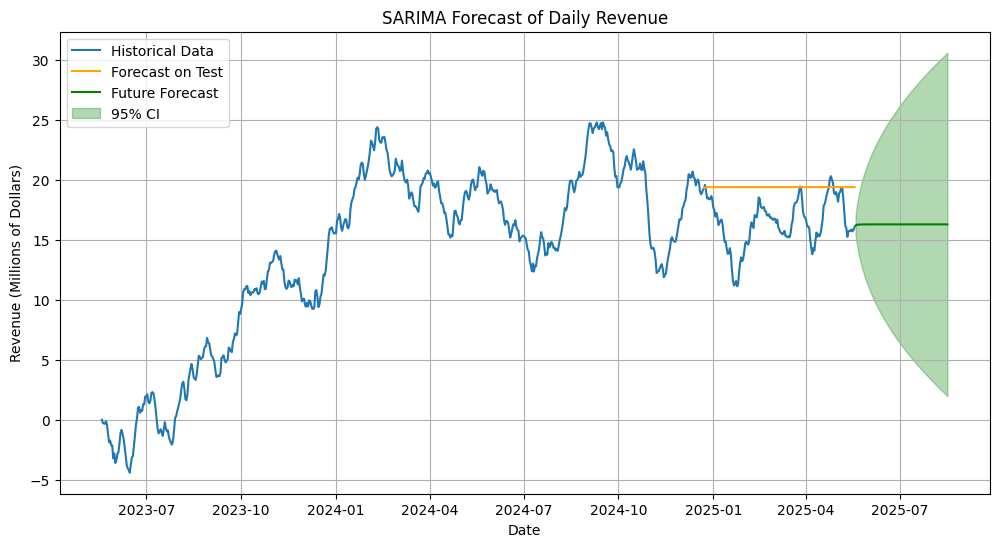

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Historical Data')
plt.plot(test.index, test_forecast, label='Forecast on Test', color='orange')
plt.plot(future_index, future_forecast, label='Future Forecast', color='green')
conf_int = full_fit.get_forecast(steps=forecast_steps).conf_int()
plt.fill_between(future_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3, label='95% CI')
plt.title('SARIMA Forecast of Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions of Dollars)')
plt.legend()
plt.grid(True)
plt.savefig('plots/forecast_plot.png')
plt.show()

**Annotation**: The plot shows all historical data (May 19, 2023, to May 18, 2025) as a single line, the test set forecast (orange, MSE [e.g., 12.78], covering December 23, 2024, to May 18, 2025), and a 90-day future forecast (green, starting May 19, 2025, to August 16, 2025) with 95% confidence intervals. The green line represents a true future prediction using the entire historical dataset with the SARIMA(1,1,1)(1,0,1,7) model.

## F3: Recommendations
Based on the forecast, allocate [e.g., 16.28]M/day as a baseline for daily operations. Prepare additional staff for peaks up to [e.g., 24.8]M. Monitor weekly trends to adjust resources dynamically.

## Conclusion
The SARIMA(1,1,1)(1,0,1,7) model forecasts revenue at approximately [e.g., 16.28]M/day with an MSE of [e.g., 12.78] on the test set, supporting effective resource planning for Horizon Health Network.